In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../') # path to bemcs

import bemcs
import bemcs.kernels_stress_displacement as kernels

class element_labels:
    def __init__(self,elements,H,L):
        xmid = np.zeros((len(elements),1))
        ymid = np.zeros((len(elements),1))
        for i in range(len(elements)):
            xmid[i] = elements[i]["x_center"]
            ymid[i] = elements[i]["y_center"]
        self.top = ymid == H # top
        self.right = xmid == L # right
        self.bot = ymid == -H # top
        self.left = xmid == -L # left
        self.interior = (xmid>-L) & (xmid<L) \
            & (ymid>-H) & (ymid<H) 

# Wavy fault in a box
Below we consider a toy problem based on laboratory rock deformation experiments. A sinusoidal fault is embedded inside a rectangular uniform elastic rectangular box. 

The boundary conditions for this problem are as follows:
- $u_x = 1, u_y = 0$ at the top
- $u_x = -1, u_y = 0$ at the bottom
- traction-free boundary conditions on the left, right and interior fault elements

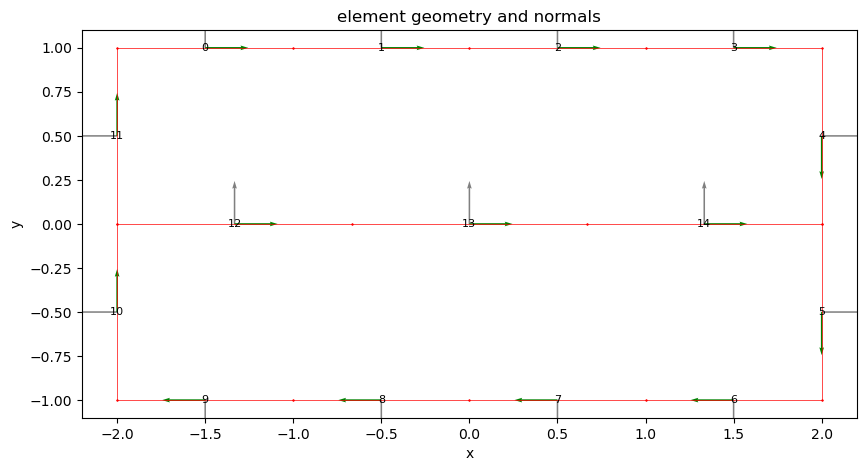

In [2]:
# Elastic parameters
mu = 1
nu = 0.25

# create a box mesh with a sinusoidal fault in the middle
L = 2.
H = 1.
ngrid = 1
corners = np.array([[-L, H], [L, H], [L, -H], [-L, -H], [-L, H]])

# Create arrays of the x and y coordinates of the corners
x, z = [], []
for i in range(4):
    lsegment = np.sqrt((corners[i,0]-corners[(i+1),0])**2 + (corners[i,1]-corners[(i+1),1])**2)
    xi = np.linspace(corners[i][0], corners[(i + 1) % 4][0], num=round(lsegment*ngrid/H), endpoint=False)
    zi = np.linspace(corners[i][1], corners[(i + 1) % 4][1], num=round(lsegment*ngrid/H), endpoint=False)
    x.append(xi)
    z.append(zi)
x.append(corners[0,0])
z.append(corners[0,1])
x = np.hstack(x)
z = np.hstack(z)

x1 = x[0:-1]
x2 = x[1:]
y1 = z[0:-1]
y2 = z[1:]
n_elements = len(x1)
elements = []
element = {}
for i in range(n_elements):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements.append(element.copy())
# Create a sinusoidal fault centered around y=0
x = np.linspace(-L,L,int(2*L/H*ngrid))
z = 0.*H*np.sin(4*np.pi*x/2/L)
# force the first and last z-values to be 0
z[0] = 0
z[-1] = 0

x1 = x[0:-1]
x2 = x[1:]
y1 = z[0:-1]
y2 = z[1:]
n_elements = len(x1)
for i in range(n_elements):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements.append(element.copy())

elements = bemcs.standardize_elements(elements)
n_elements = len(elements)

plt.figure(figsize=(10,6))
bemcs.plot_element_geometry(elements)
plt.show()

# add labels for top,right,bot,left,interior
labels = element_labels(elements,H,L)

## Identifying open nodes, overlapping interior nodes and triple junctions automatically

In [3]:
# first find all unique points
points = np.zeros((n_elements*2,2))
x1y1 = np.zeros((n_elements,2))
x2y2 = np.zeros((n_elements,2))
xmid = np.zeros((len(elements),1))
ymid = np.zeros((len(elements),1))
nvec = np.zeros((n_elements,2))

for i in range(n_elements):
    x1y1[i,:] = np.hstack((elements[i]["x1"],elements[i]["y1"]))
    x2y2[i,:] = np.hstack((elements[i]["x2"],elements[i]["y2"]))
    points[2*i,:] = x1y1[i]
    points[2*i+1,:] = x2y2[i]
    nvec[i,:] = np.array((elements[i]["x_normal"],elements[i]["y_normal"]))
    xmid[i] = elements[i]["x_center"]
    ymid[i] = elements[i]["y_center"]

unique_points, id_unique = np.unique(points, axis = 0, return_index=True)

# find number of open, 2-overlap & triple junction nodes
index_matrix1 = []
index_matrix2 = []
index_matrix3 = []

for i in range(len(unique_points)):
    pts = unique_points[i,:].reshape(1,-1)
    
    # which element(s) contains this point 
    id1 = np.where(np.all(pts == x1y1, axis = 1))
    id2 = np.where(np.all(pts == x2y2, axis = 1))

    # the negative signs are for the triple junction equations 
    # s_1 + s_2 + s_3 = 0 with the negative sign going to any 2 elements that are both id1 or id2 
    if np.size(id1) == 2:
        id_combo = np.hstack((-id1[0]*3,id2[0]*3 + 2))
    elif np.size(id2) == 2:
        id_combo = np.hstack((id1[0]*3,-(id2[0]*3 + 2)))
    else:
        id_combo = np.hstack((id1[0]*3,id2[0]*3 + 2))

    if np.size(id_combo) == 1:
        index_matrix1.append(id_combo)
    elif np.size(id_combo) == 2:
        index_matrix2.append(id_combo)
    elif np.size(id_combo) == 3:
        index_matrix3.append(id_combo)
    else:
        print(id_combo)
        raise ValueError("Cannot deal with more than 3 lines at a node")

print("Number of open nodes =", len(index_matrix1)) 
print(":", index_matrix1)
print("Number of 2-overlap nodes =", len(index_matrix2)) 
print(":", index_matrix2)
print("Number of triple junctions =", len(index_matrix3)) 
print(":", index_matrix3)

N_c = 2*len(elements) # central node equations
N_o = 2*len(index_matrix1) # open node equations
N_i = 4*len(index_matrix2) # overlapping node equations
N_t = 6*len(index_matrix3) # triple junction equations

Number of open nodes = 0
: []
Number of 2-overlap nodes = 12
: [array([30, 29]), array([ 0, 35]), array([27, 26]), array([3, 2]), array([39, 38]), array([24, 23]), array([6, 5]), array([42, 41]), array([21, 20]), array([9, 8]), array([18, 17]), array([12, 11])]
Number of triple junctions = 2
: [array([-33, -36,  32]), array([ 15, -14, -44])]


In [4]:
# Nequations = N_c + N_o + N_i + N_t
Nequations = N_c + N_o + N_i + N_t
Nunknowns = len(elements)*6

# We will stack this with 
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
BC_c = np.zeros((N_c,1)) # these are the only non-zero entries
BC_o = np.zeros((N_o,1))
BC_i = np.zeros((N_i,1))
BC_t = np.zeros((N_t,1))

# Boundary conditions are
# top: ux = 1, uy = 0
# right: traction-free
# bot: ux = -1, uy = 0
# left: traction-free
# interior: traction-free
bc_x = np.zeros((len(elements),1))
bc_y = np.zeros((len(elements),1))

bc_x[labels.top] = 1.
bc_y[labels.top] = 0.
bc_x[labels.bot] = -1.
bc_y[labels.bot] = 0.

bc_x[labels.right] = 0.
bc_y[labels.right] = 0.
bc_x[labels.left] = 0.
bc_y[labels.left] = 0.

bc_x[labels.interior] = 0.
bc_y[labels.interior] = 0.

BC_c[0::2] = bc_x
BC_c[1::2] = bc_y
# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c,BC_o,BC_i,BC_t))

In [5]:
# design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip,matrix_slipgradient = kernels.get_designmatrix_xy_3qn(elements,flag="node")
    
# patch center locations (need to be shifted an infinitesimal amount in -ve unit normal direction)
obs_xy = (np.hstack((xmid,ymid)) - nvec*1e-6)
x_obs = obs_xy[:,0].reshape(-1,1)
y_obs = obs_xy[:,1].reshape(-1,1)

# compute shear and tensile stress kernels evaluated ONLY at the center of each element

# kernels are [Kxx,Kyy,Kxy,Gx,Gy] x [Nobs x Ncoefficients]
# the last argument passed is a flag for shear/tensile source (1 - shear, 0 - tensile)
kernels_s = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,1)
kernels_n = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,0)

# convert to traction kernels [Nobs x Ncoefficients]
# tx = Kxx*nx + Kxy*ny
# ty = Kxy*nx + Kyy*ny
tractionkernels_s = kernels.compute_tractionkernels(elements,kernels_s)
tractionkernels_n = kernels.compute_tractionkernels(elements,kernels_n)


# Issue (working on it)
Need to figure out indexing for adding traction kernels into the design matrix

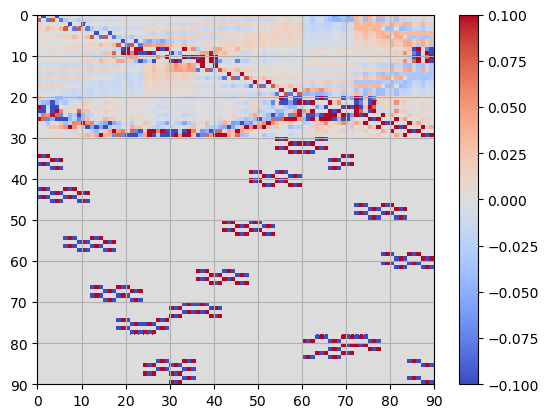

In [26]:
# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c,Nunknowns))
matrix_system_o = np.zeros((N_o,Nunknowns))
matrix_system_i = np.zeros((N_i,Nunknowns))
matrix_system_t = np.zeros((N_t,Nunknowns))

# Linear operator for central node BCs 
kerneleval_x = np.zeros((n_elements,Nunknowns))
kerneleval_y = np.zeros((n_elements,Nunknowns))

for i in range(5):
    if i == 0:
        idx = labels.top.flatten()
        kernel_for_x_s = kernels_s[3]
        kernel_for_x_n = kernels_s[3]
        kernel_for_y_s = kernels_s[4]
        kernel_for_y_n = kernels_s[4]
    elif i == 1:
        idx = labels.bot.flatten()
        kernel_for_x_s = kernels_s[3]
        kernel_for_x_n = kernels_s[3]
        kernel_for_y_s = kernels_s[4]
        kernel_for_y_n = kernels_s[4]
    elif i == 2:        
        idx = labels.left.flatten()
        kernel_for_x_s = tractionkernels_s[0]
        kernel_for_x_n = tractionkernels_n[0]
        kernel_for_y_s = tractionkernels_s[1]
        kernel_for_y_n = tractionkernels_n[1]
    elif i == 3:        
        idx = labels.right.flatten()
        kernel_for_x_s = tractionkernels_s[0]
        kernel_for_x_n = tractionkernels_n[0]
        kernel_for_y_s = tractionkernels_s[1]
        kernel_for_y_n = tractionkernels_n[1]
    else:
        idx = labels.interior.flatten()
        kernel_for_x_s = tractionkernels_s[0]
        kernel_for_x_n = tractionkernels_n[0]
        kernel_for_y_s = tractionkernels_s[1]
        kernel_for_y_n = tractionkernels_n[1]

    # x-kernels
    kerneleval_x[idx,0::6] = kernel_for_x_s[idx,0::3]
    kerneleval_x[idx,1::6] = kernel_for_x_s[idx,1::3]
    kerneleval_x[idx,2::6] = kernel_for_x_s[idx,2::3]
    kerneleval_x[idx,3::6] = kernel_for_x_n[idx,0::3]
    kerneleval_x[idx,4::6] = kernel_for_x_n[idx,1::3]
    kerneleval_x[idx,5::6] = kernel_for_x_n[idx,2::3]

    # y-kernels
    kerneleval_y[idx,0::6] = kernel_for_y_s[idx,0::3]
    kerneleval_y[idx,1::6] = kernel_for_y_s[idx,1::3]
    kerneleval_y[idx,2::6] = kernel_for_y_s[idx,2::3]
    kerneleval_y[idx,3::6] = kernel_for_y_n[idx,0::3]
    kerneleval_y[idx,4::6] = kernel_for_y_n[idx,1::3]
    kerneleval_y[idx,5::6] = kernel_for_y_n[idx,2::3]

# populate matrix_system for central nodes
matrix_system_c[0::2,:] = kerneleval_x
matrix_system_c[1::2,:] = kerneleval_y

# Linear operator for open nodes
for i in range(int(N_o/2)):
    id1 = index_matrix1[i] # node number
    matrix_system_o[2*i,:] = matrix_slip[2*id1,:] # x component
    matrix_system_o[2*i+1,:] = matrix_slip[2*id1+1,:] # y component

# Linear operator for overlapping nodes
for i in range(int(N_i/4)):
    idvals = index_matrix2[i] # node number
    # continuity condition
    matrix_system_i[4*i,:] = matrix_slip[2*idvals[0],:] - matrix_slip[2*idvals[1],:] # x
    matrix_system_i[4*i+1,:] = matrix_slip[2*idvals[0]+1,:] - matrix_slip[2*idvals[1]+1,:] # y
    # smoothing constraints
    matrix_system_i[4*i+2,:] = matrix_slipgradient[2*idvals[0],:] - matrix_slipgradient[2*idvals[1],:] # x
    matrix_system_i[4*i+3,:] = matrix_slipgradient[2*idvals[0]+1,:] - matrix_slipgradient[2*idvals[1]+1,:] # y


# Linear operator for triple junction nodes
for i in range(int(N_t/6)):
    id1 = index_matrix3[i]
    idvals = np.abs(id1)

    id_neg = idvals[id1 < 0] # node number that need to be subtracted in TJ kinematics
    id_pos = idvals[id1 >= 0] # node numbers that need to be added
    # triple junction kinematics equations
    if len(id_neg)==2:
        matrix_system_t[6*i,:] = matrix_slip[2*id_pos,:] - matrix_slip[2*id_neg[0],:] - matrix_slip[2*id_neg[1],:] # x component
        matrix_system_t[6*i+1,:] = matrix_slip[2*id_pos+1,:] - matrix_slip[2*id_neg[0]+1,:] - matrix_slip[2*id_neg[1]+1,:] # y component
    else:
        matrix_system_t[6*i,:] = matrix_slip[2*id_pos[0],:] + matrix_slip[2*id_pos[1],:] - matrix_slip[2*id_neg,:] # x component
        matrix_system_t[6*i+1,:] = matrix_slip[2*id_pos[0]+1,:] + matrix_slip[2*id_pos[1]+1,:] - matrix_slip[2*id_neg+1,:] # y component

    # smoothing constraints (2 nodes at a time)
    matrix_system_t[6*i+2,:] = matrix_slipgradient[2*idvals[0],:] - matrix_slipgradient[2*idvals[1],:] # x
    matrix_system_t[6*i+3,:] = matrix_slipgradient[2*idvals[0]+1,:] - matrix_slipgradient[2*idvals[1]+1,:] # y
    matrix_system_t[6*i+4,:] = matrix_slipgradient[2*idvals[0],:] - matrix_slipgradient[2*idvals[2],:] # x
    matrix_system_t[6*i+5,:] = matrix_slipgradient[2*idvals[0]+1,:] - matrix_slipgradient[2*idvals[2]+1,:] # y

# stack the matrices and create the full linear operator
matrix_system = np.vstack((matrix_system_c,matrix_system_o,matrix_system_i,matrix_system_t))

# plot design matrix
_,ax = plt.subplots()
pc = ax.pcolor(matrix_system,cmap="coolwarm",shading='flat')
ax.grid(which='both')
ax.invert_yaxis()
pc.set_clim(-0.1,0.1)
plt.colorbar(pc)
plt.show()


# Solve system

In [58]:
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.pinv(matrix_system) @ BCvector
print("Linear Operator Condition Number:", np.linalg.cond(matrix_system))

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((len(elements)*3,1))
quadratic_coefs_n = np.zeros((len(elements)*3,1))
for i in range(len(elements)):
    quadratic_coefs_s[3*i:3*(i+1)] = quadratic_coefs[6*i:6*i+3]
    quadratic_coefs_n[3*i:3*(i+1)] = quadratic_coefs[6*i+3:6*(i+1)]

# print(np.hstack((quadratic_coefs_s,quadratic_coefs_n)))
print(matrix_system_c@quadratic_coefs)

Linear Operator Condition Number: 83641.77881035322
[[ 1.00000000e+00]
 [ 2.42736915e-14]
 [ 1.00000000e+00]
 [ 2.37306935e-14]
 [ 1.00000000e+00]
 [ 4.07674772e-15]
 [ 1.00000000e+00]
 [-6.18664630e-14]
 [ 1.59328014e-14]
 [-3.09691185e-14]
 [ 1.27109526e-14]
 [-6.10012272e-15]
 [-1.00000000e+00]
 [ 1.58278290e-15]
 [-1.00000000e+00]
 [ 7.24088334e-15]
 [-1.00000000e+00]
 [ 2.55209282e-14]
 [-1.00000000e+00]
 [-1.04207780e-14]
 [-3.69517078e-14]
 [-2.65759711e-14]
 [-1.04567522e-15]
 [-1.10328488e-14]
 [ 2.29867114e-14]
 [-8.88691741e-15]
 [ 6.79810771e-15]
 [-1.78093974e-15]
 [-2.95492241e-15]
 [ 5.85735783e-16]]


# Plot displacement and stress components in the medium

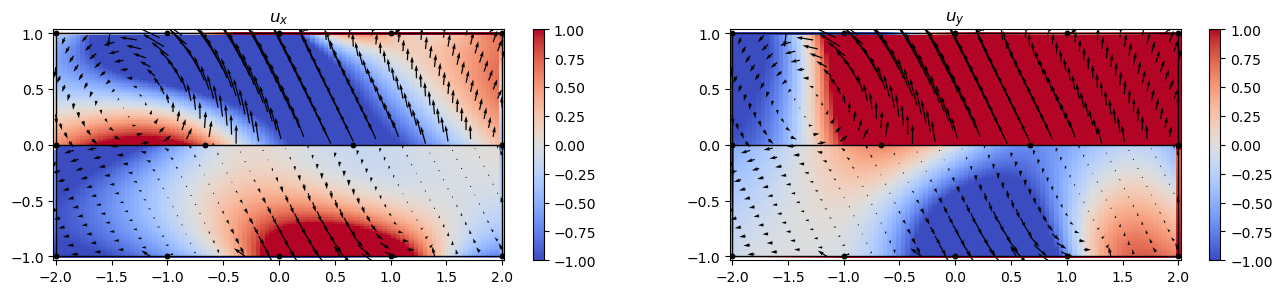

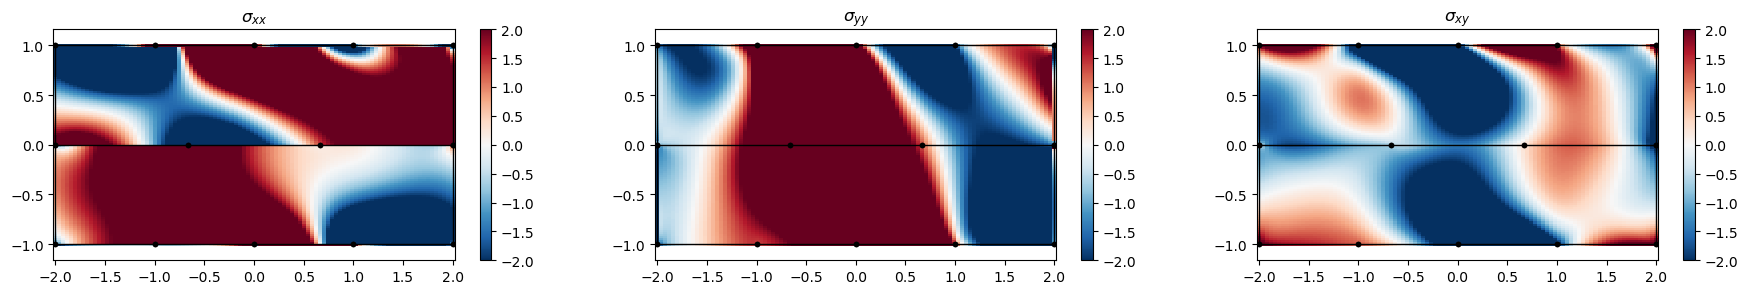

In [57]:
# observation point
n_obs = 100
width = 2
x_obs = np.linspace(-width, width, n_obs)
y_obs = np.linspace(-width/2, width/2, n_obs)

x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# compute shear and tensile stress kernels
# kernels are [Kxx,Kyy,Kxy,Gx,Gy] x [Nobs x Ncoefficients]
# the last argument passed is a flag for shear/tensile source (1 - shear, 0 - tensile)
kernels_s = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,1)
kernels_n = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,0)

# compute displacement and stresses (we will plot it later)
ux = kernels_s[3] @ (quadratic_coefs_s) + kernels_n[3] @ quadratic_coefs_n
uy = kernels_s[4] @ (quadratic_coefs_s) + kernels_n[4] @ quadratic_coefs_n
sxx = kernels_s[0] @ (quadratic_coefs_s) + kernels_n[0] @ quadratic_coefs_n
syy = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
sxy = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n

nskip_plot = 21 # plotting for vectors

# displacements
plt.figure(figsize=(16,3))
plt.subplot(1, 2, 1)
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), ux.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.clim(-1,1)
plt.colorbar()
plt.quiver(x_obs[0::nskip_plot],y_obs[0::nskip_plot],ux[0::nskip_plot],uy[0::nskip_plot])
plt.axis("equal")
plt.title("$u_x$")

plt.subplot(1, 2, 2)
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), uy.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.clim(-1,1)
plt.colorbar()
plt.quiver(x_obs[0::nskip_plot],y_obs[0::nskip_plot],ux[0::nskip_plot],uy[0::nskip_plot])
plt.title("$u_y$")
plt.axis("equal")
plt.show()

# plot stresses
plt.figure(figsize=(22, 3))
plt.subplot(1, 3, 1)
toplot = sxx
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='RdBu_r',vmin=-1.5,vmax=1.5)
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-2,2)
plt.axis("equal")
plt.title("$\sigma_{xx}$")

plt.subplot(1, 3, 2)
toplot = syy
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='RdBu_r',vmin=-1.5,vmax=1.5)
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-2,2)
plt.axis("equal")
plt.title("$\sigma_{yy}$")

plt.subplot(1, 3, 3)
toplot = sxy
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='RdBu_r',vmin=-1.5,vmax=1.5)
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-2,2)
plt.axis("equal")
plt.title("$\sigma_{xy}$")
plt.show()